In [1]:
import numpy as np
import matplotlib.pyplot as plt


from jlinops import _CustomLinearOperator
import jlinops

# IPCG

In [2]:
def cg(A, b, x0=None, atol=1e-5, maxiter=None, residual_method="approximate", x_true=None):
    """Implements preconditioned conjugate gradient method.
    """

    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    # Get shape
    n = A.shape[0]
    if maxiter is None: maxiter = n

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # Setup
    r_prev = b - (A @ x)
    p = r_prev.copy()
    n_its = 0
    residual_norms = [ np.linalg.norm(r_prev) ]
    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = x_err

    # Should we terminate before starting?
    if np.linalg.norm(r_prev) < atol:
        pass

    else:

        for i in range(maxiter):
            Ap = A @ p
            alpha = np.dot(r_prev, r_prev)/np.dot(p, Ap)
            x += alpha*p
            r_next = r_prev - alpha*Ap
            n_its += 1

            if residual_method == "approximate":
                residual = r_next
            elif residual_method == "exact":
                residual = b - (A @ x)
            else:
                raise NotImplementedError
            residual_norms.append( np.linalg.norm(residual) )

            if np.linalg.norm(residual) < atol: break

            beta = np.dot(r_next, r_next)/np.dot(r_prev, r_prev)
            p = r_next + beta*p
            r_prev = r_next.copy()

            # Track err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)


    data = {
        "x": x,
        "n_its": n_its,
        "residual_norms": np.asarray(residual_norms),
    }

    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)

    return data


In [3]:
# np.random.seed(0)
# n = 100
# A = np.random.normal(size=(n, n))
# A = A.T @ A
# b = np.random.normal(size=n)
# data = cg(A, b, x0=None, atol=1e-3, maxiter=1000)
# ref = np.linalg.solve(A, b)
# np.linalg.norm( b - A @ data["x"] )
# #np.linalg.norm(ref - data["x"])

In [79]:
def ipcg(A, b, M, x0=None, rtol=1e-3, eta=1.0, e_norm=1.0, maxiter=None, Mcond=None, beta_formula="polyak-ribiere", residual_method="exact", x_true=None):
    """Represents inexact preconditioned CG method.

    e_norm: expected value of the vector e.
    """

    assert beta_formula in ["polyak-ribiere", "fletcher-reeves"], "invalid beta_formula parameter!"
    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    # Get shape
    n = A.shape[0]
    if maxiter is None: maxiter = n

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # eta
    eta_tilde = eta/np.sqrt(Mcond)

    # bnorm
    bnorm = np.linalg.norm(b)

    # Setup
    r_prev = np.zeros(n)
    p = r_prev.copy()
    r_next = b - (A @ x)
    beta = 0
    residual_norms = [np.linalg.norm(r_next)]

    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = [ x_err ] 

    n_inner_its = 0
    n_outer_its = 0

    # Should we terminate before starting?
    if np.linalg.norm(r_next)/bnorm < rtol:
        pass

    else:

        for i in range(maxiter):
            
            cgdata = cg(M, r_next, atol=eta_tilde*np.linalg.norm(r_next) )
            n_inner_its += cgdata["n_its"]
            z_next = cgdata["x"]

            if i > 1:
                if beta_formula == "polyak-ribiere":
                    beta = np.dot( z_next, r_next - r_prev ) / np.dot(z_prev, r_prev)
                elif beta_formula == "fletcher-reeves":
                    beta = np.dot( z_next, r_next ) / np.dot( z_prev, r_prev )
                else:
                    raise NotImplementedError

            p = z_next + beta*p
            Ap = A @ p
            alpha = np.dot(z_next, r_next)/(np.dot(p, Ap))
            r_prev = r_next.copy()
            r_next -= alpha * Ap
            x += alpha*p
            z_prev = z_next.copy()

            # Store residual
            if residual_method == "approximate":
                residual_norms.append( np.linalg.norm( r_prev ) )
            elif residual_method == "exact":
                residual_norms.append( np.linalg.norm( b - (A @ x) ) )
            else:
                raise NotImplementedError
            
            # Break?
            if np.linalg.norm(r_prev)/bnorm < rtol:
                break
            n_outer_its += 1
            
            # Track x_err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)

    data = {
        "x": x,
        "residual_norms": np.asarray(residual_norms),
        "n_inner_its": n_inner_its,
        "n_outer_its": n_outer_its,
    }
    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)
    
    return data
    

# Try IPCG

In [80]:
n = 100
R, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
R = R.toarray()

np.random.seed(0)
w = np.random.uniform(low=5, high=45, size=R.shape[0])

Amat = R.T @ np.diag(w) @ R
A = jlinops.MatrixLinearOperator(Amat)
Mmat = R.T @ R
M = jlinops.MatrixLinearOperator(Mmat)
Mcond = np.linalg.cond(Mmat)
Minv_mat = np.linalg.inv(Mmat)
Minv = jlinops.MatrixLinearOperator(Minv_mat)
b = np.random.normal(size=n)
x_true = np.linalg.solve(Amat, b)

# Make class for representing linear operator with error
class ArtificialErrorSPDLinearOperator(_CustomLinearOperator):

    def __init__(self, A, delta, method="inner"):
        
        self.Atrue = A
        self.delta = delta
        shape = A.shape

        assert method in ["inner", "outer"], "invalid method choice!"
        
        if method == "outer":
            _matvec = lambda x: self.Atrue.matvec(x) + delta*np.random.normal(size=shape[0])
        elif method == "inner":
            _matvec = lambda x: self.Atrue.matvec( x + delta*np.random.normal(size=shape[0]) )
        else:
            raise NotImplementedError

        super().__init__(shape, _matvec, _matvec, device=A.device)

### Try on simple problem

In [81]:
# Try it on a simple problem
data2 = ipcg(A, b, M, x0=None, x_true=x_true, eta=1e-1, maxiter=None, Mcond=Mcond, beta_formula="fletcher-reeves", residual_method="approximate")
data = ipcg(A, b, M, x0=None, x_true=x_true, eta=1e-1, maxiter=None, Mcond=Mcond, beta_formula="polyak-ribiere", residual_method="approximate")
print(np.linalg.norm(b - A @ data["x"]))
print(Mcond)

0.0035380597144905926
16370.242143024154


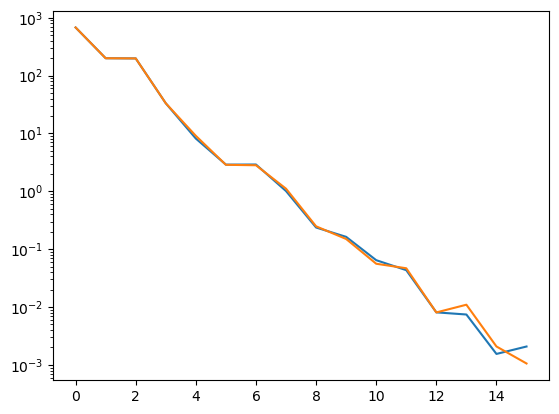

In [82]:
plt.semilogy(data["x_errs"])
plt.semilogy(data2["x_errs"])
plt.show()

# Study parameters

In [96]:
# Try it on a simple problem
maxiter = 50
eta = 1e2
rtol = 1e-3

# np.random.seed(1)
# x0 = np.random.normal(size=A.shape[0])
x0 = None

data2 = ipcg(A, b, M, x0=x0, x_true=x_true, rtol=rtol, eta=eta, maxiter=maxiter, Mcond=Mcond, beta_formula="fletcher-reeves", residual_method="approximate")
data = ipcg(A, b, M, x0=x0, x_true=x_true, rtol=rtol, eta=eta, maxiter=maxiter, Mcond=Mcond, beta_formula="polyak-ribiere", residual_method="approximate")
print(np.linalg.norm(b - A @ data["x"]))
print(Mcond)

6.517625724552683
16370.242143024154


In [97]:
print("Polyak-Ribiere method")
print("===============")
print(data["n_outer_its"])
print(data["n_inner_its"])
print("")
print("Fletcher-Reeves method")
print("===============")
print(data2["n_outer_its"])
print(data2["n_inner_its"])
print("")

Polyak-Ribiere method
50
134

Fletcher-Reeves method
50
134



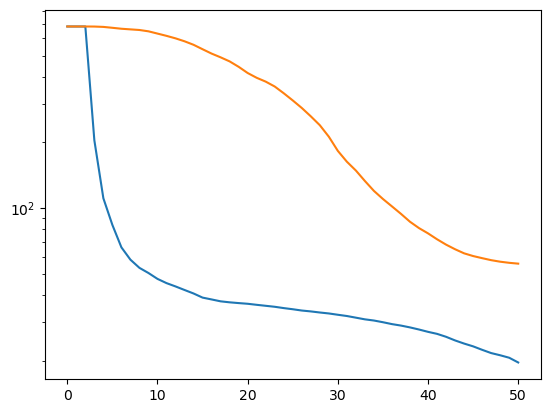

In [101]:
plt.semilogy(data["x_errs"])
plt.semilogy(data2["x_errs"])
plt.show()

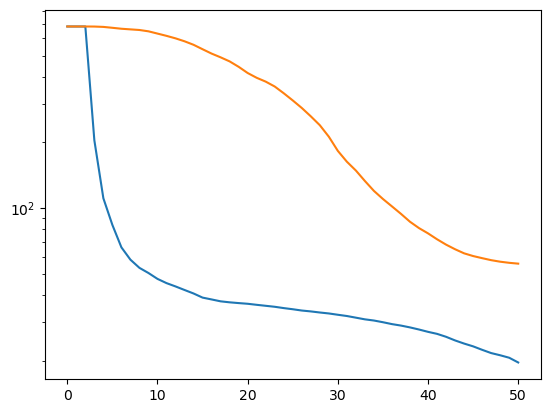

In [99]:
plt.semilogy(data["x_errs"])
plt.semilogy(data2["x_errs"])
plt.show()

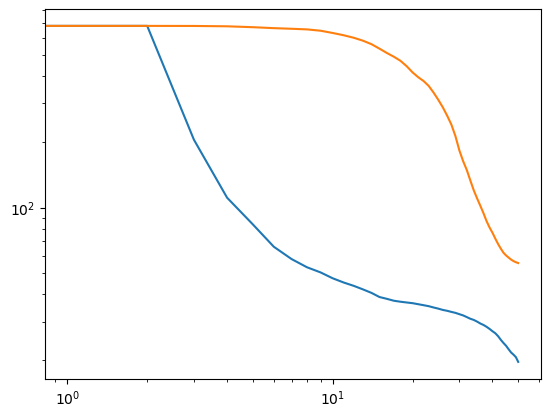

In [100]:
plt.loglog(data["x_errs"])
plt.loglog(data2["x_errs"])
plt.show()

# Pick eta using the heuristic

In [87]:
# Try it on a simple problem

L = np.linalg.cholesky(Mmat)
Linv = np.linalg.inv(L)
Zcond = np.linalg.cond(Linv @ Amat @ Linv.T)
eta = 1.0/(2*np.sqrt(Zcond))
print(eta)

maxiter = 200
#eta = 1e0
rtol = 1e-4

# np.random.seed(1)
# x0 = np.random.normal(size=A.shape[0])
x0 = None

data2 = ipcg(A, b, M, x0=x0, x_true=x_true, rtol=rtol, eta=eta, maxiter=maxiter, Mcond=Mcond, beta_formula="fletcher-reeves", residual_method="approximate")
data = ipcg(A, b, M, x0=x0, x_true=x_true, rtol=rtol, eta=eta, maxiter=maxiter, Mcond=Mcond, beta_formula="polyak-ribiere", residual_method="approximate")
print(np.linalg.norm(b - A @ data["x"]))
print(Mcond)

0.1706522082007994
3.719976432441347e-08
16370.242143024154


In [90]:
print("Polyak-Ribiere method")
print("===============")
print(data["n_outer_its"])
print(data["n_inner_its"])
print("")
print("Fletcher-Reeves method")
print("===============")
print(data2["n_outer_its"])
print(data2["n_inner_its"])
print("")

Polyak-Ribiere method
30
2916

Fletcher-Reeves method
31
2974



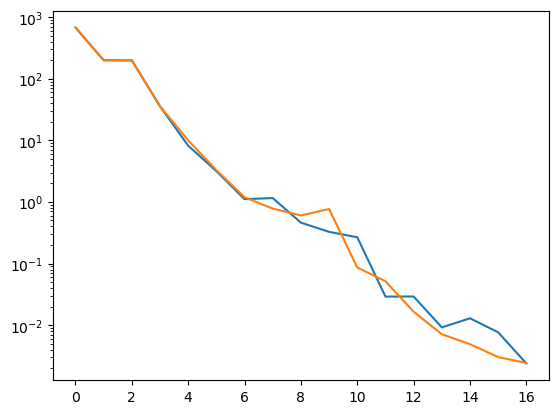

In [94]:
plt.semilogy(data["x_errs"])
plt.semilogy(data2["x_errs"])
plt.show()

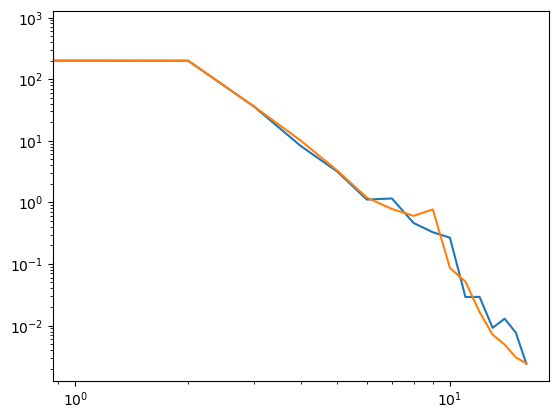

In [95]:
plt.loglog(data["x_errs"])
plt.loglog(data2["x_errs"])
plt.show()